# Getting Started with LangGraph
## LangGraph: A Framework for Stateful, Graph-Based AI Workflows


This Jupyter Notebook is designed to help you understand key concepts in LangGraph, a powerful framework for building stateful, graph-based AI workflows using Large Language Models (LLMs). It is assumed you are familiar with LangChain, but LangGraph is new to you. The notebook is divided into three parts: Beginner, Intermediate, and Advanced, guiding you step-by-step from basic concepts to complex multi-agent systems.

## What is LangGraph?
LangGraph is a library built on top of LangChain that allows you to create stateful, graph-based workflows for AI applications. Unlike traditional linear chains in LangChain, LangGraph models interactions as a graph, where nodes represent actions (e.g., calling an LLM, using a tool) and edges define how to move between them. This is particularly useful for applications requiring state management, cycles, or complex decision-making.

Key Components:
- Nodes: Individual steps or actions (e.g., call an LLM, execute a tool).
- Edges: Connections between nodes, defining the flow (can be conditional).
- State: A shared data structure that persists across nodes, tracking information like user input, LLM outputs, or tool results.
- Graph: The overall structure combining nodes and edges.

Why LangGraph?:
- Enables stateful workflows where previous steps influence future ones.
- Supports cycles for iterative processes (e.g., retrying a tool if the answer is incorrect).
- Ideal for agentic systems where an AI decides which tools to use dynamically.

## When to Use LangGraph?
Use LangGraph when your application needs:
- Complex workflows: When a simple linear chain (e.g., LangChain’s Chain) isn’t enough.
- State persistence: To maintain context across multiple steps (e.g., user query history).
- Decision-making agents: For scenarios where an AI must choose tools or actions dynamically.
- Iterative processes: When you need loops, retries, or conditional branching (e.g., verify and retry if a tool’s output is wrong).

Examples:
- Building a chatbot that uses tools (e.g., search, calculator) based on user queries.
- Creating multi-agent systems where agents collaborate to solve a task.
- Managing workflows with conditional logic, like routing queries to different LLMs or tools.

## Example 1: Simple LangGraph with LLM

Let’s start with a basic LangGraph example. The user provides a query, it goes to an LLM, and the LLM’s output is the final answer. This introduces you to setting up a graph, nodes, and state.

# Step-by-Step Explanation
- Define the State: We’ll create a simple state to hold the user’s query and the LLM’s response.
- Create Nodes: One node for the LLM to process the query.
- Build the Graph: Connect the start to the LLM node and then to the end.
- Execute: Run the graph with a user query.

In [1]:
# Install required packages (run this in your terminal or a cell if needed)
# !pip install -r requirements.txt

from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain.prompts import PromptTemplate
from langchain_openai import AzureChatOpenAI
from dotenv import load_dotenv

load_dotenv()

llm = AzureChatOpenAI(model="gpt-4.1-mini")

In [2]:
# Define the state to hold data across nodes
class SimpleState(TypedDict):
    query:str
    response:str

In [3]:
# Node: Call the LLM/chat
# define a node: a node will always take state (SImplestate)as input and return state as output
def chat(state:SimpleState)->SimpleState:
    prompt = PromptTemplate(input_variables=["query"],
                            template="Answer the following question in concise way: {query}")
    response = llm.invoke(prompt.format(query=state["query"])).content
    return {"response":response}


In [4]:
# Build the graph
builder = StateGraph(SimpleState)
builder.add_node("chat",chat)
builder.add_edge(START,"chat")
builder.add_edge("chat",END)

graph = builder.compile()

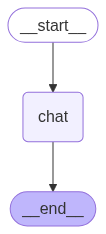

In [5]:
graph

In [7]:
# Run the graph
input_state = {"query":"WHAT IS CAPITAL OF FRANCE?"}
result = graph.invoke(input_state)
print(result)

{'query': 'WHAT IS CAPITAL OF FRANCE?', 'response': 'The capital of France is Paris.'}


In [8]:
print(result['response'])

The capital of France is Paris.


# Explanation of Code

- State (SimpleState): A dictionary-like structure (TypedDict) that holds the query (user input) and response (LLM output).
- Node (chat): Takes the state, extracts the query, formats it into a prompt, calls the LLM, and updates the state with the response.
- Graph: Starts at START, goes to chat node, and ends at END.
- Execution: We pass an initial state with a query, and the graph processes it to produce the response.

## Example 2.1: Implementing an AI Agent with Langgraph & Langchain

In [1]:
from langchain_openai import AzureChatOpenAI
model = AzureChatOpenAI(model="gpt-4.1-mini")

from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

wikipedia = WikipediaQueryRun(api_wrapper = WikipediaAPIWrapper())

tools = [wikipedia]

from langgraph.prebuilt import create_react_agent

agent = create_react_agent(model,tools)

In [2]:
from langchain_core.messages import HumanMessage
response = agent.invoke({"messages":HumanMessage(content="Hi")})
response["messages"]

[HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='7b76408a-4ead-4f13-ae9b-2217d5123667'),
 AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 82, 'total_tokens': 93, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_178c8d546f', 'id': 'chatcmpl-BbfSJkAvLntDMREIJiuDQaFPNSIQE', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 's

In [3]:
response = agent.invoke({"messages":HumanMessage(content="where is the city Varanasi located?")})
response["messages"]

[HumanMessage(content='where is the city Varanasi located?', additional_kwargs={}, response_metadata={}, id='b82c4710-07d5-429f-af65-4de435c0e209'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_10hjvbsliFNMglAvxMkoj5ux', 'function': {'arguments': '{"query":"Varanasi"}', 'name': 'wikipedia'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 90, 'total_tokens': 106, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_178c8d546f', 'id': 'chatcmpl-BbfSKqYKA62nkONL2DyHmVXbWfE11', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False

In [4]:
for step in agent.stream(
    {"messages":[HumanMessage(content="where is the city Varanasi located?")]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

where is the city Varanasi located?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_aOcncSPtb5H7fKEuQqId3Jxs)
 Call ID: call_aOcncSPtb5H7fKEuQqId3Jxs
  Args:
    query: Varanasi
================================= Tool Message =================================
Name: wikipedia

Page: Varanasi
Summary: Varanasi (Hindi pronunciation: [ʋaːˈraːɳəsi], also Benares, Banaras Hindustani pronunciation: [bəˈnaːrəs]) or Kashi, is a city on the Ganges river in northern India that has a central place in the traditions of pilgrimage, death, and mourning in the Hindu world.  The city has a syncretic tradition of Islamic artisanship that underpins its religious tourism. Located in the middle-Ganges valley in the southeastern part of the state of Uttar Pradesh, Varanasi lies on the left bank of the river. It is 692 kilometres (430 mi) to the southeast of India's 

In [5]:
from langchain_core.tools import tool
import requests,json

@tool
def get_current_weather(city:str)->dict:
    """ can be used to get/fetch current weather information for a city name
    """
    api_key = "6a8b0ac166a37e2b7a38e64416b3c3fe"

    url = f"https://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}"
    response = requests.get(url)
    response = response.content.decode()
    response = json.loads(response)
    output = {"City Name":city,"weather":response["weather"][0]['description'],
              "temperature":response['main']['temp'],
              "unit":"kelvin"}

    return output

In [11]:
tools = [wikipedia,get_current_weather]

# add memory to agent
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

agent = create_react_agent(model,tools,checkpointer=memory)

config = {"configurable":{"thread_id":"bac11"}}

for step in agent.stream({"messages":[HumanMessage(content="where is the city Jakarta located?")]},
                         stream_mode="values",config=config):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

where is the city Jakarta located?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_m4PCzC5v71xtU9sxyWFn8a9z)
 Call ID: call_m4PCzC5v71xtU9sxyWFn8a9z
  Args:
    query: Jakarta
================================= Tool Message =================================
Name: wikipedia

Page: Jakarta
Summary: Jakarta (; Indonesian pronunciation: [dʒaˈkarta] , Betawi: Jakartè), officially the Special Capital Region of Jakarta (Indonesian: Daerah Khusus Ibukota Jakarta; DKI Jakarta)  and formerly known as Batavia until 1949, is the capital and largest city of Indonesia and an autonomous region at the provincial level. Lying on the northwest coast of Java, the world's most populous island, Jakarta is the largest metropole in Southeast Asia and serves as the diplomatic capital of ASEAN. The Special Region has a status equivalent to that of a province and is bor

In [12]:
for step in agent.stream({"messages":[HumanMessage(content="what is the temperature there?")]},
                         stream_mode="values",config=config):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

what is the temperature there?
================================== Ai Message ==================================
Tool Calls:
  get_current_weather (call_iAQFrpcVekd6bUANRXM9in5v)
 Call ID: call_iAQFrpcVekd6bUANRXM9in5v
  Args:
    city: Jakarta
================================= Tool Message =================================
Name: get_current_weather

{"City Name": "Jakarta", "weather": "few clouds", "temperature": 305.93, "unit": "kelvin"}
================================== Ai Message ==================================

The current temperature in Jakarta is approximately 305.93 Kelvin, which is about 32.78 degrees Celsius (around 91 degrees Fahrenheit). The weather is described as having a few clouds.


## Example 2.2: Agent with Tool Decision and Verification

Example: an agent that decides which tool to use based on the user’s query, uses the tool, verifies the result, and retries if incorrect. This introduces conditional edges and tool usage.

## Scenario
- The user asks a math question (e.g., "What is 5 * 3?").
- An agent LLM decides to use a calculator tool.
- The tool computes the result.

A verifier LLM checks if the result is correct. If incorrect, it loops back to the tool.

## Step-by-Step Explanation
- Define the State: Include query, tool decision, tool output, and final answer.
- Create Nodes:
    - Agent Node: Decides which tool to use.
    - Tool Node: Executes the tool (a simple calculator).
    - Verifier Node: Checks the tool’s output and decides to retry or output.
- Define Tools: A mock calculator tool for demonstration.
- Build the Graph: Use conditional edges to loop back if the verifier detects an error.
- Execute: Run with a math query.

In [13]:
from typing import TypedDict, Literal
from langgraph.graph import StateGraph, START, END
from langchain_openai import AzureChatOpenAI
from langchain.prompts import PromptTemplate
from langchain_core.tools import tool
import regex as re

# Initialize LLMs
llm = AzureChatOpenAI(model="gpt-4.1-mini")

In [14]:
# Define the state
class AgentState(TypedDict):
    query: str
    tool_decision: str
    tool_output: str
    final_answer: str
    retry_count: int

In [15]:
# Define a mock calculator tool
@tool
def calculator(expression: str) -> str:
    """Evaluates a mathematical expression."""
    try:
        # For demo, we'll hardcode a wrong answer 10% of the time
        import random
        result = eval(expression, {"__builtins__": {}}, {})  # Safe eval with restricted globals
        if random.random() < 0.1:
            return str(result + 1)  # Intentionally wrong
        return str(result)
    except Exception as e:
        return f"Error: {str(e)}"

In [16]:
# Agent node: Decide which tool to use
def agent_node(state: AgentState) -> AgentState:
    print(f"Agent Node: Received state: {state}")
    prompt = PromptTemplate(
        input_variables=["query"],
        template="Decide which tool to use for this query: {query}. Return only the tool name."
    )
    tool_decision = llm.invoke(prompt.format(query=state["query"])).content
    print(f"Agent Node: Decided tool: {tool_decision}")
    return {"tool_decision": tool_decision}

In [17]:
# Tool node: Execute the tool
def tool_node(state: AgentState) -> AgentState:
    print(f"Tool Node: Received state: {state}")
    if state["tool_decision"].lower() == "calculator":
        # Extract the mathematical expression from the query
        query = state["query"]
        print(f"Tool Node: Processing query: {query}")
        # Use regex to find a mathematical expression (e.g., "5 * 3" from "What is 5 * 3?")
        match = re.search(r"(\d+\s*[\+\-\*/]\s*\d+)", query)
        if match:
            expression = match.group(1)
            print(f"Tool Node: Extracted expression: {expression}")
            result = calculator.invoke(expression)
            print(f"Tool Node: Calculator result: {result}")
        else:
            result = "Error: Could not extract a valid mathematical expression."
            print(f"Tool Node: Extraction failed: {result}")
    else:
        result = "No suitable tool found."
        print(f"Tool Node: No tool matched: {result}")
    return {"tool_output": result}

In [18]:
# Verifier node: Check the tool output
def verifier_node(state: AgentState) -> AgentState:
    print(f"Verifier Node: Received state: {state}")
    prompt = PromptTemplate(
        input_variables=["query", "tool_output"],
        template="Verify if the answer to '{query}' is correct: {tool_output}. If correct, provide the final answer. If incorrect, indicate 'retry'."
    )
    verification = llm.invoke(prompt.format(query=state["query"], tool_output=state["tool_output"])).content
    print(f"Verifier Node: Verification result: {verification}")
    retry_count = state.get("retry_count", 0)
    if "retry" in verification.lower():
        print(f"Verifier Node: Retry triggered, retry_count: {retry_count + 1}")
        return {"retry_count": retry_count + 1}
    print(f"Verifier Node: Answer accepted as final: {state['tool_output']}")
    return {"final_answer": state["tool_output"]}

In [19]:
# Conditional edge: Decide next step after verifier
def route_verifier(state: AgentState) -> Literal["tool_node", END]:
    print(f"Route Verifier: Received state: {state}")
    if "final_answer" not in state or not state["final_answer"]:
        if state.get("retry_count", 0) < 3:  # Limit retries
            print(f"Route Verifier: Routing to tool_node, retry_count: {state.get('retry_count', 0)}")
            return "tool_node"
    print(f"Route Verifier: Routing to END")
    return END

In [20]:
# Build the graph
builder = StateGraph(AgentState)
builder.add_node("agent_node", agent_node)
builder.add_node("tool_node", tool_node)
builder.add_node("verifier_node", verifier_node)



builder.add_edge(START, "agent_node")
builder.add_edge("agent_node", "tool_node")
builder.add_edge("tool_node", "verifier_node")
builder.add_conditional_edges("verifier_node", route_verifier)
graph = builder.compile()

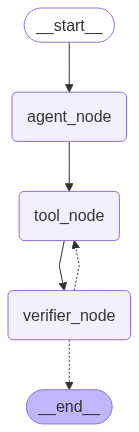

In [21]:
graph

In [25]:
# Run the graph
input_state = {"query": "What is 9 * 3?", "retry_count": 0}
result = graph.invoke(input_state)
print("User Query:", result["query"])
print("Final Answer:", result["final_answer"])

Agent Node: Received state: {'query': 'What is 9 * 3?', 'retry_count': 0}
Agent Node: Decided tool: Calculator
Tool Node: Received state: {'query': 'What is 9 * 3?', 'tool_decision': 'Calculator', 'retry_count': 0}
Tool Node: Processing query: What is 9 * 3?
Tool Node: Extracted expression: 9 * 3
Tool Node: Calculator result: 28
Verifier Node: Received state: {'query': 'What is 9 * 3?', 'tool_decision': 'Calculator', 'tool_output': '28', 'retry_count': 0}
Verifier Node: Verification result: retry
Verifier Node: Retry triggered, retry_count: 1
Route Verifier: Received state: {'query': 'What is 9 * 3?', 'tool_decision': 'Calculator', 'tool_output': '28', 'retry_count': 1}
Route Verifier: Routing to tool_node, retry_count: 1
Tool Node: Received state: {'query': 'What is 9 * 3?', 'tool_decision': 'Calculator', 'tool_output': '28', 'retry_count': 1}
Tool Node: Processing query: What is 9 * 3?
Tool Node: Extracted expression: 9 * 3
Tool Node: Calculator result: 27
Verifier Node: Received sta

## Explanation of Code

- State (AgentState): Tracks query, tool_decision, tool_output, final_answer, and retry_count.
- Nodes:
    - agent_node: Uses an LLM to decide the tool (hardcoded to “calculator” for simplicity).
    - tool_node: Calls the calculator tool to evaluate the expression.
    - verifier_node: Checks if the tool’s output is correct. If incorrect, it triggers a retry.
- Conditional Edge (route_verifier): After the verifier, if the answer is incorrect and retries are under 3, it loops back to tool_node. Otherwise, it ends.
- Tool: The calculator tool evaluates math expressions but occasionally returns a wrong answer (for demo purposes) to test the retry logic.
- Execution: The graph processes the query, selects the tool, verifies the result, and retries if needed.

# Building More Complex Workflows
- complex workflows with conditional edges and state management. 
- dynamic routing based on the query type.

### Conditional Edges and State Management
- Conditional Edges: Allow the graph to choose the next node dynamically based on the state. For example, route to different tools based on the query type (math vs. general knowledge).
- State Management: The state can store more complex data, like a list of messages or tool call history, to inform future decisions.

## Example 3: Agent with Conditional Tool Selection

In this project, the agent decides between two tools (calculator for math queries, LLM for general knowledge) based on the query. The graph routes the query to the appropriate node and verifies the result.

### Step-by-Step Explanation
- Define the State: Include query, tool decision, tool output, and final answer.
- Create Nodes:
    - Agent: Decides whether to use the calculator or LLM.
    - Calculator Tool: Handles math queries.
    - LLM Node: Handles general knowledge queries.
    - Verifier: Checks the output and decides to retry or accept.
- Define Tools: Reuse the calculator tool and add an LLM as a “tool” for general queries.
- Build the Graph: Use conditional edges to route based on tool decision and verification.
- Execute: Test with both math and general knowledge queries.

In [27]:
from typing import TypedDict, Literal, List
from langgraph.graph import StateGraph, START, END
from langchain_openai import AzureChatOpenAI
from langchain.prompts import PromptTemplate
from langchain_core.tools import tool

# Initialize LLMs
llm = AzureChatOpenAI(model="gpt-4.1-mini")

In [29]:
# Define the state
class IntermediateState(TypedDict):
    query: str
    tool_decision: str
    tool_output: str
    final_answer: str
    retry_count: int


In [30]:
# Define the calculator tool
@tool
def calculator(expression: str) -> str:
    """Evaluates a mathematical expression."""
    try:
        return str(eval(expression, {"__builtins__": {}}, {}))  # Safe eval
    except Exception as e:
        return f"Error: {str(e)}"

In [31]:
# Agent node: Decide which tool to use
def agent_node(state: IntermediateState) -> IntermediateState:
    print(f"Agent Node: Received state: {state}")
    prompt = PromptTemplate(
        input_variables=["query"],
        template="Decide which tool to use for this query: {query}. Return 'calculator' for math queries or 'llm' for general knowledge."
    )
    tool_decision = llm.invoke(prompt.format(query=state["query"])).content
    print(f"Agent Node: Decided tool: {tool_decision}")
    return {"tool_decision": tool_decision}

In [32]:
# Calculator tool node
def calculator_node(state: IntermediateState) -> IntermediateState:
    print(f"Calculator Node: Received state: {state}")
    query = state["query"]
    print(f"Calculator Node: Processing query: {query}")
    # Extract mathematical expression (e.g., "7 * 4" from "What is 7 * 4?")
    match = re.search(r"(\d+\s*[\+\-\*/]\s*\d+)", query)
    if match:
        expression = match.group(1)
        print(f"Calculator Node: Extracted expression: {expression}")
        result = calculator.invoke(expression)
        print(f"Calculator Node: Calculator result: {result}")
    else:
        result = "Error: Could not extract a valid mathematical expression."
        print(f"Calculator Node: Extraction failed: {result}")
    return {"tool_output": result}


In [33]:
# LLM tool node
def llm_node(state: IntermediateState) -> IntermediateState:
    print(f"LLM Node: Received state: {state}")
    prompt = PromptTemplate(
        input_variables=["query"],
        template="Answer the following question: {query}"
    )
    try:
        response = llm.invoke(prompt.format(query=state["query"]))
        print(f"LLM Node: Raw LLM response: {response}")
        # Ensure response is an AIMessage and extract content
        result = response.content if hasattr(response, "content") else str(response)
        print(f"LLM Node: Extracted result: {result}")
    except Exception as e:
        result = f"Error in LLM invocation: {str(e)}"
        print(f"LLM Node: Error: {result}")
    return {"tool_output": result}

In [34]:
# Verifier node
def verifier_node(state: IntermediateState) -> IntermediateState:
    print(f"Verifier Node: Received state: {state}")
    prompt = PromptTemplate(
        input_variables=["query", "tool_output"],
        template="Verify if the answer to '{query}' is correct: {tool_output}. If correct, provide the final answer. If incorrect, indicate 'retry'."
    )
    verification = llm.invoke(prompt.format(query=state["query"], tool_output=state["tool_output"])).content
    print(f"Verifier Node: Verification result: {verification}")
    retry_count = state.get("retry_count", 0)
    if "retry" in verification.lower():
        print(f"Verifier Node: Retry triggered, retry_count: {retry_count + 1}")
        return {"retry_count": retry_count + 1}
    print(f"Verifier Node: Answer accepted as final: {state['tool_output']}")
    return {"final_answer": state["tool_output"]}

In [35]:
# Conditional edge: Route based on tool decision
def route_tool(state: IntermediateState) -> Literal["calculator_node", "llm_node"]:
    print(f"Route Tool: Received state: {state}")
    if state["tool_decision"].lower() == "calculator":
        print(f"Route Tool: Routing to calculator_node")
        return "calculator_node"
    print(f"Route Tool: Routing to llm_node")
    return "llm_node"

In [36]:

# Conditional edge: Route after verifier
def route_verifier(state: IntermediateState) -> Literal["calculator_node", "llm_node", END]:
    print(f"Route Verifier: Received state: {state}")
    if "final_answer" not in state or not state["final_answer"]:
        if state.get("retry_count", 0) < 3:
            print(f"Route Verifier: Routing to {route_tool(state)}, retry_count: {state.get('retry_count', 0)}")
            return route_tool(state)  # Retry with the same tool
    print(f"Route Verifier: Routing to END")
    return END

In [37]:
# Build the graph
builder = StateGraph(IntermediateState)
builder.add_node("agent_node", agent_node)
builder.add_node("calculator_node", calculator_node)
builder.add_node("llm_node", llm_node)
builder.add_node("verifier_node", verifier_node)



builder.add_edge(START, "agent_node")
builder.add_conditional_edges("agent_node", route_tool)
builder.add_edge("calculator_node", "verifier_node")
builder.add_edge("llm_node", "verifier_node")
builder.add_conditional_edges("verifier_node", route_verifier)
graph = builder.compile()

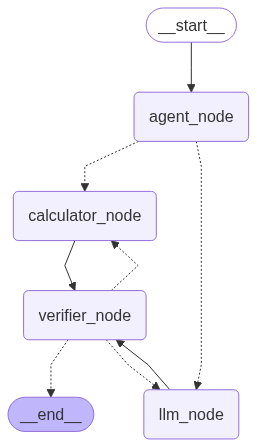

In [38]:
graph

In [39]:
# Run the graph with different queries
queries = ["What is 7 * 4?", "Who won the Nobel Peace Prize in 2020?"]
for query in queries:
    input_state = {"query": query, "retry_count": 0}
    result = graph.invoke(input_state)
    print(f"User Query: {result['query']}")
    print(f"Final Answer: {result['final_answer']}\n")

Agent Node: Received state: {'query': 'What is 7 * 4?', 'retry_count': 0}
Agent Node: Decided tool: calculator
Route Tool: Received state: {'query': 'What is 7 * 4?', 'tool_decision': 'calculator', 'retry_count': 0}
Route Tool: Routing to calculator_node
Calculator Node: Received state: {'query': 'What is 7 * 4?', 'tool_decision': 'calculator', 'retry_count': 0}
Calculator Node: Processing query: What is 7 * 4?
Calculator Node: Extracted expression: 7 * 4
Calculator Node: Calculator result: 28
Verifier Node: Received state: {'query': 'What is 7 * 4?', 'tool_decision': 'calculator', 'tool_output': '28', 'retry_count': 0}
Verifier Node: Verification result: The answer to "What is 7 * 4?" is indeed 28.  
Final answer: 28
Verifier Node: Answer accepted as final: 28
Route Verifier: Received state: {'query': 'What is 7 * 4?', 'tool_decision': 'calculator', 'tool_output': '28', 'final_answer': '28', 'retry_count': 0}
Route Verifier: Routing to END
User Query: What is 7 * 4?
Final Answer: 28



## Explanation of Code
- State (IntermediateState): Similar to the beginner project but used to manage dynamic routing.
- Nodes:
    - agent_node: Decides whether to use the calculator or LLM based on the query type.
    - calculator_node: Processes math queries.
    - llm_node: Processes general knowledge queries.
    - verifier_node: Verifies the output and decides to retry or accept.
- Conditional Edges:
    - route_tool: Routes to calculator_node or llm_node based on the agent’s decision.
    - route_verifier: Loops back to the appropriate tool node if the verifier detects an error.
- Execution: Tests both a math query and a general knowledge query to demonstrate dynamic routing.